## Parameter Estimation using Metropolis-Hastings Algorithm (MCMC) 


Actual model
$$ \frac{d{\alpha}}{dt} = (K_1 + K_2 \alpha^m)(\alpha_{max} - \alpha)^n $$
where $\alpha$ is the degree-of-cure (between 0 and 1), $\alpha_{max} = 0.9$ is the maximum
degree-of-cure achieved in an isothermal scan. m, n are kinetic exponents
(unknowns), K1; K2 are the unknown kinetic parameters, described based of:
$$ K_i = A_i \exp(-E_i/RT) $$
where A_i and E_i are the frequency factors and activation energy. R is the universal gas constant
and T is the temperature (in Kelvin). 
The initial degree-of-cure ( $\alpha$ at time = 59.02002
seconds) is 0:01.

#### Problem
Using the MCMC algorithm and the experimental data given, compute
the K_i parameters for Equation (3) and visualize the uncertainty about
the response by taking several samples.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp 
from scipy.stats import norm, uniform

In [2]:
# Import the data
data_path = "Kinetic data/Cure kinetics 90C data - Exercise.XLS"
data = pd.read_excel(data_path)
data.head(10)

,Time (s),Temp (C),Degree of Cure,Cure Rate
0,59.02002,90.1120,0.010000,NaN
1,60.01980,90.1129,0.010189,0.000191
2,61.02000,90.1126,0.010381,0.000194
3,62.02020,90.1130,0.010575,0.000197
4,63.01980,90.1136,0.010773,0.000199
5,64.02000,90.1133,0.010973,0.000202
6,65.02020,90.1134,0.011175,0.000205
7,66.01980,90.1139,0.011381,0.000208
8,67.02000,90.1145,0.011591,0.000211
9,68.02020,90.1143,0.011802,0.000214


In [3]:
alpha = data['Degree of Cure']
time = data['Time (s)']
d_alpha = data['Cure Rate']

### Visualization


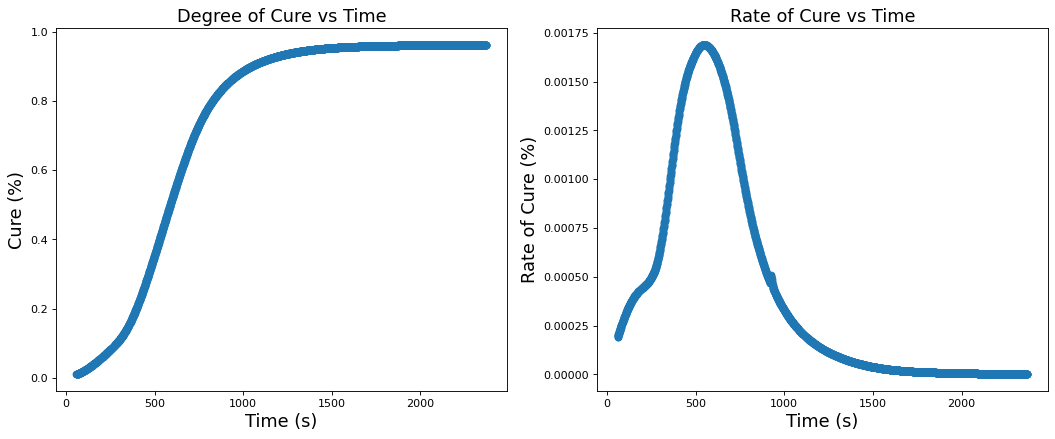

In [4]:
# plot the two above plots together using subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=80)
ax1.plot(data['Time (s)'], data['Degree of Cure'], 'o')
ax1.set_xlabel('Time (s)', fontsize=16)
ax1.set_ylabel('Cure (%)', fontsize=16)
ax1.set_title('Degree of Cure vs Time', fontsize=16)
ax2.plot(data['Time (s)'], data['Cure Rate'], 'o')
ax2.set_xlabel('Time (s)', fontsize=16)
ax2.set_ylabel('Rate of Cure (%)', fontsize=16)
ax2.set_title('Rate of Cure vs Time', fontsize=16)
plt.show()


In [5]:
class MCMC:
    def __init__(self, alpha, dalpha, n_iter, n_burn, n_thin, sigma=0.1, **kwargs):
        self.alpha = alpha
        self.dalpha = dalpha
        self.n_iter = n_iter
        self.n_burn = n_burn
        self.n_thin = n_thin
        self.sigma = sigma
        self.chain = None
        self.running_mean = None
        self.running_var = None
        self.k1_init, self.k2_init, self.m_init, self.n_init = kwargs.get('init', [0.1, 0.1, 0.1, 0.1])
        self.k1_mean, self.k2_mean, self.m_mean, self.n_mean = kwargs.get('mean', [0.1, 0.1, 0.1, 0.1])
    
    def model(self, k1, k2, m, n, alpha):
        alpha_max = .9
        # define model
        dalpha = (k1 + k2*alpha**m)*(alpha_max - alpha)**n
        return dalpha

    def likelihood(self, theta):
        k1 = theta[0]
        k2 = theta[1]
        m = theta[2]
        n = theta[3]
        # calculate model
        dalpha_model = self.model(k1, k2, m, n, self.alpha)
        # calculate likelihood (Error function)
        L = -0.5*np.sum(np.log(2*np.pi*self.sigma**2) + (self.dalpha - dalpha_model)**2/self.sigma**2)
        return L

    def prior(self, theta):
        k1 = theta[0]
        k2 = theta[1]
        m = theta[2]
        n = theta[3]
        std = 0.1
        # use a normal distribution for the prior
        p = norm.pdf(k1, self.k1_mean, std)*norm.pdf(k2, self.k2_mean, std)*norm.pdf(m, self.m_mean, std)*norm.pdf(n, self.n_mean, std)
        return p
    
    def posterior(self, theta):
        # calculate prior
        p = self.prior(theta)
        # calculate likelihood
        l = self.likelihood(theta)
        # calculate posterior
        post = p*l
        return post
    
    def run(self):
        # initialize the chain
        chain = np.zeros((self.n_iter, 4))
        running_mean = np.zeros((self.n_iter, 4))
        running_var = np.zeros((self.n_iter, 4))
        # initialize the parameters
        k1 = self.k1_init
        k2 = self.k2_init
        m = self.m_init
        n = self.n_init
        # initialize the acceptance counter
        acc = 0
        # initialize the acceptance rate
        acc_rate = 0
        # loop over iterations
        for i in range(self.n_iter):
            # update the parameters
            k1_new = np.random.normal(k1, self.sigma)
            k2_new = np.random.normal(k2, self.sigma)
            m_new = np.random.normal(m, self.sigma)
            n_new = np.random.normal(n, self.sigma)
            # define the new parameters
            theta_new = np.array([k1_new, k2_new, m_new, n_new])
            # calculate the acceptance ratio
            r = self.posterior(theta_new)/self.posterior(np.array([k1, k2, m, n]))
            # accept or reject the new parameters
            if r > 1:
                k1 = k1_new
                k2 = k2_new
                m = m_new
                n = n_new
                acc += 1
            else:
                u = np.random.uniform(0, 1)
                if u < r:
                    k1 = k1_new
                    k2 = k2_new
                    m = m_new
                    n = n_new
                    acc += 1

            # update the acceptance rate
            acc_rate = acc/(i+1)
            # update the chain
            chain[i, :] = np.array([k1, k2, m, n])
            # update the running mean
            running_mean[i, :] = np.mean(chain[:i+1, :], axis=0)
            # update the running variance
            running_var[i, :] = np.var(chain[:i+1, :], axis=0)
            # print the acceptance rate
            if (i+1) % 1000 == 0:
                print(f'Iteration: {i+1}, Acceptance Rate: {acc_rate}')
        # update the chain
        self.chain = chain
        # update the running mean
        self.running_mean = running_mean
        # update the running variance
        self.running_var = running_var
        

The code above defines a Markov Chain Monte Carlo (MCMC) class that implements the Metropolis-Hastings algorithm to simulate a posterior distribution. The algorithm is applied to estimate the parameters of a model, given some observed data.

The class has several methods, including an initialization method that sets the necessary hyperparameters and initial values for the parameters to be estimated. The model method defines the mathematical formula for the model being used. The likelihood method calculates the likelihood of the data given the model parameters. The prior method calculates the prior probability distribution for the model parameters. The posterior method calculates the posterior probability distribution for the model parameters.

The run method contains the main loop of the algorithm, which runs for n_iter iterations. At each iteration, the algorithm proposes new values for the parameters, calculates the acceptance ratio, and updates the current parameter values based on the acceptance ratio. The method also calculates and stores various statistics about the parameter estimates and the acceptance rate

In [6]:
# define the number of iterations
n_iter = 100000
# define the number of burn-in iterations
n_burn = 1000
# define the number of thinning iterations
n_thin = 10
# define the standard deviation
sigma = 0.1
# create an instance of the MCMC class
k1 = 0.0000005
k2 = 0.0003
m = 1
n = 1
k1_m = 0.00005
k2_m = 0.0085
m_m = 1
n_m = 1
kwargs = {'init': [k1, k2, m, n], 'mean': [k1_m, k2_m, m_m, n_m]}
mcmc = MCMC(alpha, d_alpha, n_iter, n_burn, n_thin, sigma = sigma, **kwargs)


In [7]:
# run the MCMC algorithm
mcmc.run()

Iteration: 1000, Acceptance Rate: 0.347
Iteration: 2000, Acceptance Rate: 0.354
Iteration: 3000, Acceptance Rate: 0.363
Iteration: 4000, Acceptance Rate: 0.367
Iteration: 5000, Acceptance Rate: 0.365
Iteration: 6000, Acceptance Rate: 0.36633333333333334
Iteration: 7000, Acceptance Rate: 0.36514285714285716
Iteration: 8000, Acceptance Rate: 0.362
Iteration: 9000, Acceptance Rate: 0.3606666666666667
Iteration: 10000, Acceptance Rate: 0.361
Iteration: 11000, Acceptance Rate: 0.35954545454545456
Iteration: 12000, Acceptance Rate: 0.35783333333333334
Iteration: 13000, Acceptance Rate: 0.35838461538461536
Iteration: 14000, Acceptance Rate: 0.3573571428571429
Iteration: 15000, Acceptance Rate: 0.35746666666666665
Iteration: 16000, Acceptance Rate: 0.35675
Iteration: 17000, Acceptance Rate: 0.35623529411764704
Iteration: 18000, Acceptance Rate: 0.3562777777777778
Iteration: 19000, Acceptance Rate: 0.35726315789473684
Iteration: 20000, Acceptance Rate: 0.3583
Iteration: 21000, Acceptance Rate: 

In [8]:
chainn = mcmc.chain
chainn = chainn[n_burn::n_thin, :]
running_mean = mcmc.running_mean
running_var = mcmc.running_var
theta_mean = np.mean(chainn, axis=0)
print(theta_mean)

[-6.17187110e-04  8.31425783e-03  1.00018220e+00  9.99206029e-01]


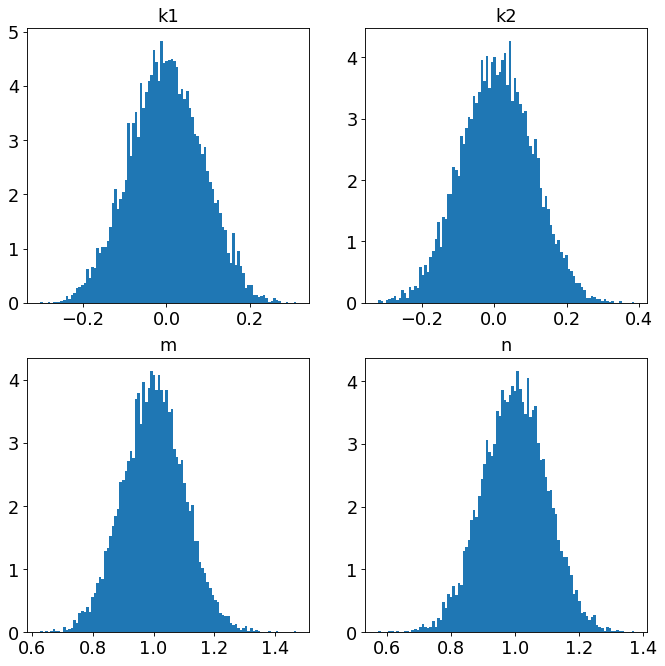

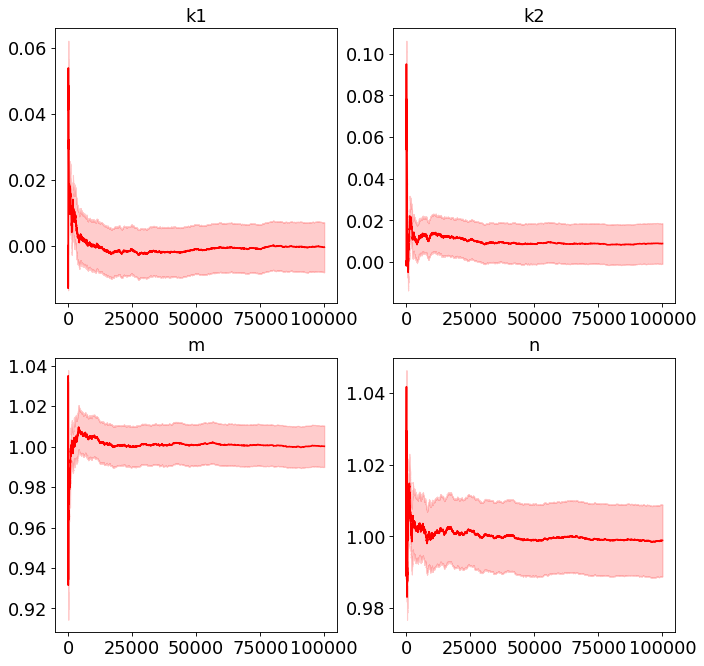

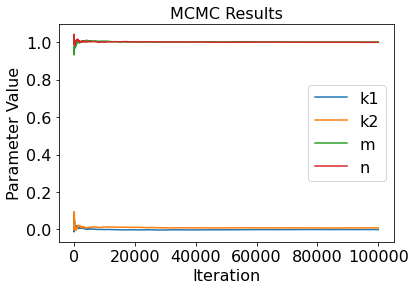

In [11]:
parameters = ['k1', 'k2', 'm', 'n']
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80)
for i in range(4):
    axs[i//2, i%2].hist(chainn[:, i], bins=100, density=True)
    axs[i//2, i%2].set_title(parameters[i], fontsize=16)
# plot the distribution of the parameters with the running mean and variance']
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80)
for i in range(4):
    axs[i//2, i%2].plot(running_mean[:, i], color='red')
    axs[i//2, i%2].fill_between(np.arange(0, n_iter), running_mean[:, i] - running_var[:, i], running_mean[:, i] + running_var[:, i], color='red', alpha=0.2)
    axs[i//2, i%2].set_title(parameters[i], fontsize=16)
# Plot the results 
plt.figure()
plt.plot(running_mean[:, 0], label='k1')
plt.plot(running_mean[:, 1], label='k2')
plt.plot(running_mean[:, 2], label='m')
plt.plot(running_mean[:, 3], label='n')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Parameter Value', fontsize=16)
plt.title('MCMC Results', fontsize=16)
plt.legend()

0.04411788308204314


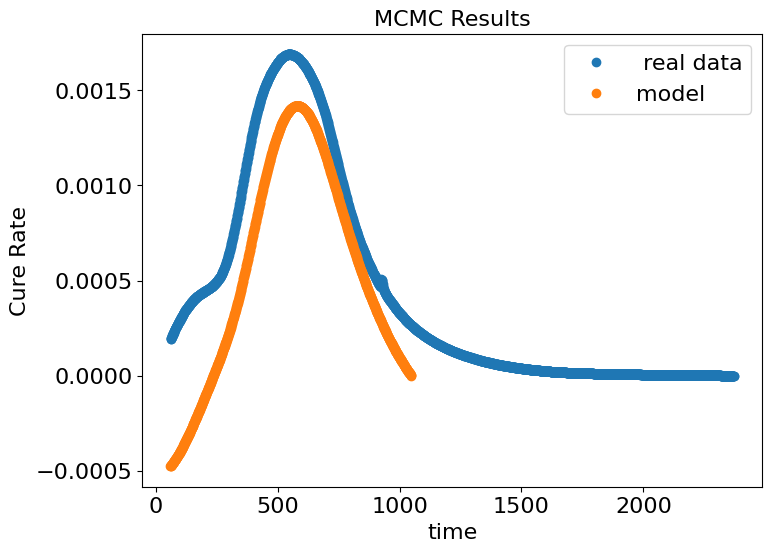

In [12]:

d_alpha_est = mcmc.model(*theta_mean, alpha)
# compare the model with the data
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(time, d_alpha, 'o', label=' real data')
plt.plot(time,d_alpha_est, 'o', label='model')
plt.xlabel('time', fontsize=16)
plt.ylabel('Cure Rate', fontsize=16)
plt.title('MCMC Results', fontsize=16)
plt.legend()
plt.rcParams.update({'font.size': 16})
dalphaa = d_alpha/np.max(d_alpha)
d_alpha_est = d_alpha_est/np.max(d_alpha_est)
error = np.mean(np.abs(dalphaa - d_alpha_est)**2)
print(error)